In [1]:
%matplotlib inline



# Fitting Robinson model (Tepit data)


In [2]:
cd /external/rprshnas01/netdata_kcni/jglab/MemberSpaces/tm/git/whobpyt

/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/tm/git/whobpyt


## Importage




In [3]:
# os stuff
import gdown
import matplotlib.pyplot as plt
# import scipy.io
import pandas as pd
import numpy as np
from whobpyt.optimization.custom_cost_JR import CostsJR
from whobpyt.optimization.modelfitting import Model_fitting
from whobpyt.models.Robinson.robinson import RNNROBINSON
from whobpyt.models.Robinson.robinson import ParamsCT
from whobpyt.data.dataload import dataloader
import whobpyt
import os
import sys
sys.path.append('..')

# whobpyt stuff

# array and pd stuff


# viz stuff

# gdown


define destination path and download data



In [4]:
cd examples

/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/tm/git/whobpyt/examples


In [5]:
des_dir = '../'
if not os.path.exists(des_dir):
    os.makedirs(des_dir)  # create folder if it does not exist
url = 'https://drive.google.com/drive/folders/1uXrtehuMlLBvPCV8zDaUYxF-MoMaD0fk'
os.chdir(des_dir)
# gdown.download_folder(url, quiet = True, use_cookies = False)
os.chdir('examples/')

get  EEG data



In [6]:
base_dir = '../Tepit/'
eeg_file = base_dir + 'eeg_data.npy'
eeg_data_all = np.load(eeg_file)
eeg_data = eeg_data_all.mean(0)

eeg_data = eeg_data[:, 700:1100] / 12*50


In [7]:
eeg_data


array([[ 2.36228259,  2.42274257,  2.48488617, ...,  2.6274691 ,
         2.00343176,  1.46210307],
       [ 1.10218536,  1.17014697,  1.1853628 , ...,  0.10279411,
        -0.42389459, -0.86431988],
       [ 2.22638001,  2.3500591 ,  2.43390133, ...,  3.49687409,
         2.8567976 ,  2.32431131],
       ...,
       [-2.34982001, -2.74432963, -3.05945711, ..., -7.52871697,
        -6.86503405, -6.37351939],
       [-2.08383656, -2.47166018, -2.81480283, ..., -5.87637781,
        -5.29003672, -4.86927024],
       [-2.33695931, -2.67794133, -2.98236018, ..., -4.08238285,
        -3.66871973, -3.34924207]])

get stimulus weights on regions



In [8]:
ki0 = np.loadtxt(base_dir + 'stim_weights.txt')[:, np.newaxis]


get SC and distance template



In [9]:
sc_file = base_dir + 'Schaefer2018_200Parcels_7Networks_count.csv'
dist_file = base_dir + 'Schaefer2018_200Parcels_7Networks_distance.csv'
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values
sc = np.log1p(sc) / np.linalg.norm(np.log1p(sc))


define options for Robinson model



In [10]:
node_size = sc.shape[0]

output_size = eeg_data.shape[0]
batch_size = 20
step_size = 1e-7
num_epoches = 30
tr = 1e-6
state_size = 16
base_batch_num = 20
time_dim = 400

hidden_size = int(tr/step_size)


prepare data structure of the model



In [11]:
data_mean = dataloader(eeg_data.T, num_epoches, batch_size)


get model parameters structure and define the fitted parameters by setting non-zero variance for the model



In [12]:
lm = np.zeros((output_size, 200))
lm_v = np.zeros((output_size, 200))
par = ParamsCT(nu_ee=[0.0528/1000, 0.00001], nu_ii=[0.0528/1000, 0.00001], nu_ei=[0.228/1000, 0.00001], lm=[lm, 1.0 * np.ones((output_size, 200))+lm_v],  # k = [10, .3],
               # cy0 = [5, 0], ki=[ki0, 0], k_aud=[k_aud0, 0], lm=[lm, 1.0 * np.ones((output_size, 200))+lm_v], \
               g=[100, 0], cy0=[5, 0.5])


In [13]:
sc.shape


(200, 200)

call model want to fit



In [14]:
model = RNNROBINSON(node_size, batch_size, step_size,
                    output_size, tr, sc, lm, dist, True, False, par)


initial model parameters and set the fitted model parameter in Tensors



In [15]:
model.setModelParameters()


create objective function



In [16]:
ObjFun = CostsJR()


call model fit



In [17]:
F = Model_fitting(model, data_mean, num_epoches, ObjFun)


model training



In [18]:
u = np.zeros((node_size, hidden_size, time_dim))
u[:, :, 110:120] = 0.15/1000
F.train(u=u, learningrate=0.01)


  3%|▎         | 1/30 [00:26<13:01, 26.93s/it]

(64, 400) (64, 400)
epoch:  0 12686.64
epoch:  0 0.28690651939718753 cos_sim:  -0.028575254931533987
Modelparam_lr 0.0006926854485228336
Hyperparam_lr 1.7317136213070835e-05


  7%|▋         | 2/30 [00:53<12:30, 26.79s/it]

(64, 400) (64, 400)
epoch:  1 12021.758
epoch:  1 0.3704667224125052 cos_sim:  -0.029493318896360067
Modelparam_lr 0.0015350481391842447
Hyperparam_lr 3.8376203479606143e-05


 10%|█         | 3/30 [01:19<11:51, 26.35s/it]

(64, 400) (64, 400)
epoch:  2 11062.06
epoch:  2 0.32581974052476564 cos_sim:  -0.029569116021909467
Modelparam_lr 0.002824360029511263
Hyperparam_lr 7.06090007377816e-05


 13%|█▎        | 4/30 [01:45<11:22, 26.26s/it]

(64, 400) (64, 400)
epoch:  3 9533.409
epoch:  3 0.45419671087091334 cos_sim:  -0.029441131336681827
Modelparam_lr 0.004403386607459641
Hyperparam_lr 0.00011008466518649105


 17%|█▋        | 5/30 [02:11<10:51, 26.06s/it]

(64, 400) (64, 400)
epoch:  4 7558.6235
epoch:  4 0.4190048603667748 cos_sim:  -0.029288202860613052
Modelparam_lr 0.006079561997114257
Hyperparam_lr 0.00015198904992785644


 20%|██        | 6/30 [02:36<10:21, 25.88s/it]

(64, 400) (64, 400)
epoch:  5 5436.5903
epoch:  5 0.6044932487800461 cos_sim:  -0.029147514995370046
Modelparam_lr 0.007648472804423447
Hyperparam_lr 0.00019121182011058618


 23%|██▎       | 7/30 [03:02<09:53, 25.82s/it]

(64, 400) (64, 400)
epoch:  6 3497.9888
epoch:  6 0.6310768758048103 cos_sim:  -0.029020024088496316
Modelparam_lr 0.008918786794666537
Hyperparam_lr 0.00022296966986666344


 27%|██▋       | 8/30 [03:28<09:26, 25.77s/it]

(64, 400) (64, 400)
epoch:  7 1967.3424
epoch:  7 0.64173309722623 cos_sim:  -0.02889688856194224
Modelparam_lr 0.009735586292843892
Hyperparam_lr 0.00024338965732109732


 30%|███       | 9/30 [03:53<09:00, 25.75s/it]

(64, 400) (64, 400)
epoch:  8 903.26855
epoch:  8 0.6336191036178942 cos_sim:  -0.02876742409607765
Modelparam_lr 0.009999860125865848
Hyperparam_lr 0.0002499965031466462


 33%|███▎      | 10/30 [04:19<08:34, 25.73s/it]

(64, 400) (64, 400)
epoch:  9 231.03238
epoch:  9 0.6342367849877919 cos_sim:  -0.028627953680000127
Modelparam_lr 0.009938441949208877
Hyperparam_lr 0.0002484610487302219


 37%|███▋      | 11/30 [04:45<08:09, 25.79s/it]

(64, 400) (64, 400)
epoch:  10 -178.22813
epoch:  10 0.6340582322740784 cos_sim:  -0.02847604196699466
Modelparam_lr 0.0097667075867032
Hyperparam_lr 0.00024416768966758


 40%|████      | 12/30 [05:11<07:47, 25.95s/it]

(64, 400) (64, 400)
epoch:  11 -427.65576
epoch:  11 0.634458304820466 cos_sim:  -0.028314815407733007
Modelparam_lr 0.0094884933002247
Hyperparam_lr 0.00023721233250561749


 43%|████▎     | 13/30 [05:38<07:23, 26.08s/it]

(64, 400) (64, 400)
epoch:  12 -586.845
epoch:  12 0.6355748206552062 cos_sim:  -0.02813861158351431
Modelparam_lr 0.009110013937198042
Hyperparam_lr 0.00022775034842995102


 47%|████▋     | 14/30 [06:04<07:00, 26.27s/it]

(64, 400) (64, 400)
epoch:  13 -700.6584
epoch:  13 0.6395649404635163 cos_sim:  -0.02791167563245569
Modelparam_lr 0.008639724101174915
Hyperparam_lr 0.00021599310252937284


 50%|█████     | 15/30 [06:31<06:35, 26.34s/it]

(64, 400) (64, 400)
epoch:  14 -804.55084
epoch:  14 0.6086777330032278 cos_sim:  -0.027297210072051457
Modelparam_lr 0.00808812928996152
Hyperparam_lr 0.00020220323224903798


 53%|█████▎    | 16/30 [06:58<06:10, 26.44s/it]

(64, 400) (64, 400)
epoch:  15 -1054.3116
epoch:  15 0.6177758999894544 cos_sim:  0.024652894202623996
Modelparam_lr 0.0074675512201573735
Hyperparam_lr 0.0001866887805039343


 57%|█████▋    | 17/30 [07:24<05:43, 26.39s/it]

(64, 400) (64, 400)
epoch:  16 -1126.1127
epoch:  16 0.627432700448111 cos_sim:  0.08518567384737585
Modelparam_lr 0.006791852580367509
Hyperparam_lr 0.0001697963145091877


 60%|██████    | 18/30 [07:50<05:17, 26.45s/it]

(64, 400) (64, 400)
epoch:  17 -1174.4432
epoch:  17 0.8788356987722039 cos_sim:  0.2759620149359285
Modelparam_lr 0.006076127361646446
Hyperparam_lr 0.00015190318404116113


 63%|██████▎   | 19/30 [08:17<04:51, 26.51s/it]

(64, 400) (64, 400)
epoch:  18 -1218.2686
epoch:  18 0.8431073433049525 cos_sim:  0.2235432703659674
Modelparam_lr 0.005336363682680086
Hyperparam_lr 0.00013340909206700216


 67%|██████▋   | 20/30 [08:44<04:25, 26.55s/it]

(64, 400) (64, 400)
epoch:  19 -1257.0637
epoch:  19 0.7337036212507836 cos_sim:  0.19082277435443576
Modelparam_lr 0.004589086641633857
Hyperparam_lr 0.00011472716604084644


 70%|███████   | 21/30 [09:10<03:57, 26.41s/it]

(64, 400) (64, 400)
epoch:  20 -1288.6688
epoch:  20 0.6331824095498384 cos_sim:  0.1783974354551244
Modelparam_lr 0.0038509891727665974
Hyperparam_lr 9.627472931916492e-05


 73%|███████▎  | 22/30 [09:36<03:30, 26.34s/it]

(64, 400) (64, 400)
epoch:  21 -1314.2539
epoch:  21 0.5658265521159919 cos_sim:  0.15876661925560664
Modelparam_lr 0.0031385591538634424
Hyperparam_lr 7.846397884658606e-05


 77%|███████▋  | 23/30 [10:03<03:05, 26.46s/it]

(64, 400) (64, 400)
epoch:  22 -1333.4207
epoch:  22 0.5715294816332763 cos_sim:  0.1328575436713219
Modelparam_lr 0.0024677110942915273
Hyperparam_lr 6.169277735728818e-05


 80%|████████  | 24/30 [10:30<02:39, 26.57s/it]

(64, 400) (64, 400)
epoch:  23 -1347.8656
epoch:  23 0.5796945730054822 cos_sim:  0.14711544987124647
Modelparam_lr 0.0018534306311586346
Hyperparam_lr 4.633576577896586e-05


 83%|████████▎ | 25/30 [10:56<02:13, 26.67s/it]

(64, 400) (64, 400)
epoch:  24 -1355.8082
epoch:  24 0.6417176050151902 cos_sim:  0.21201558660675895
Modelparam_lr 0.001309439774943247
Hyperparam_lr 3.2735994373581174e-05


 87%|████████▋ | 26/30 [11:23<01:46, 26.61s/it]

(64, 400) (64, 400)
epoch:  25 -1364.6255
epoch:  25 0.6249686679827521 cos_sim:  0.2493141655537057
Modelparam_lr 0.0008478903824553856
Hyperparam_lr 2.1197259561384637e-05


 90%|█████████ | 27/30 [11:50<01:20, 26.67s/it]

(64, 400) (64, 400)
epoch:  26 -1373.5154
epoch:  26 0.5293356712190865 cos_sim:  0.2465105439529983
Modelparam_lr 0.0004790927044358169
Hyperparam_lr 1.1977317610895421e-05


 93%|█████████▎| 28/30 [12:17<00:53, 26.71s/it]

(64, 400) (64, 400)
epoch:  27 -1385.855
epoch:  27 0.4611340581545424 cos_sim:  -0.06151481023813328
Modelparam_lr 0.00021128507159168147
Hyperparam_lr 5.282126789792035e-06


 97%|█████████▋| 29/30 [12:43<00:26, 26.60s/it]

(64, 400) (64, 400)
epoch:  28 -1389.966
epoch:  28 0.21037533992568425 cos_sim:  -0.08878870602686349
Modelparam_lr 5.0449863901923025e-05
Hyperparam_lr 1.2612465975480755e-06


100%|██████████| 30/30 [13:10<00:00, 26.34s/it]

(64, 400) (64, 400)
epoch:  29 -1364.114
epoch:  29 0.03332280444544262 cos_sim:  0.01703494629408983
Modelparam_lr 1.7987413415217968e-07
Hyperparam_lr 4.4968533538044916e-09


In [19]:
l = dir(F.output_sim)


In [20]:
np.shape(getattr(F.output_sim, 'V_e_train'))


(201, 400)

In [23]:
params_toplot= ['phi_e_dot_train',
 'phi_e_train',
 'phi_i_dot_train',
 'phi_i_train',
 'V_e_dot_train',
 'V_e_train',
 'V_i_dot_train',
 'V_i_train'] 

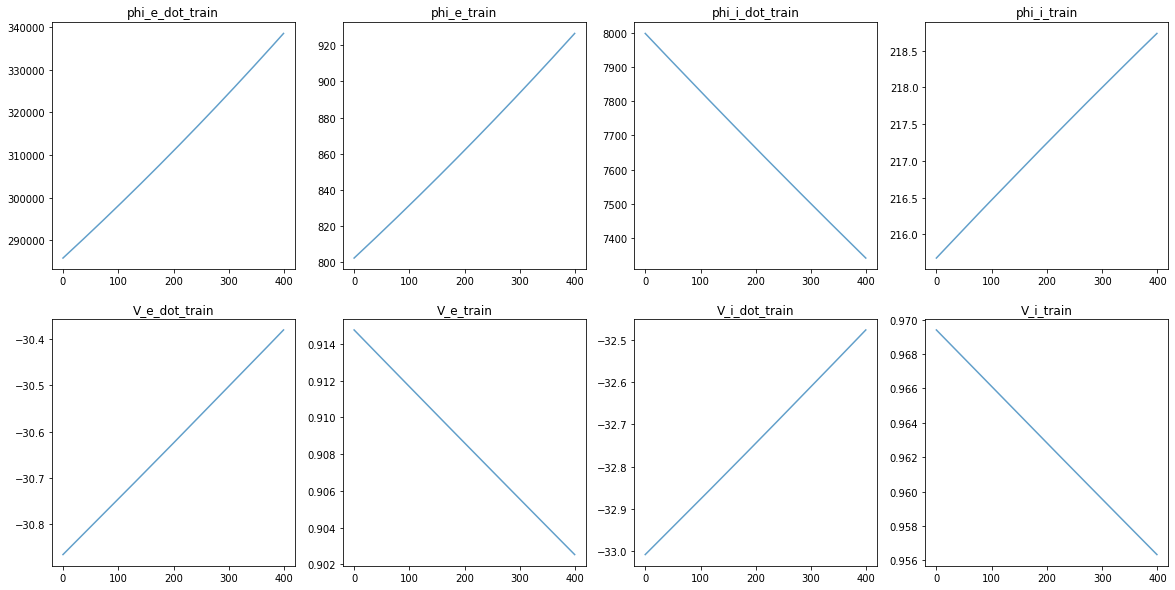

In [34]:
fig,axes=plt.subplots(ncols=4,nrows=2,figsize=(20, 10))
for n, param in enumerate(params_toplot):
    ax = axes.ravel()[n]
    ax.plot(getattr(F.output_sim,param).T.mean(axis=1), alpha=0.7)
    # plt.plot(eeg_data[i, :].T, label='data')
    ax.set(title=param)
    # ax.legend()
plt.show()


model test with 20 window for warmup



In [ ]:
F.test(200, u=u)


Plot SC and fitted SC



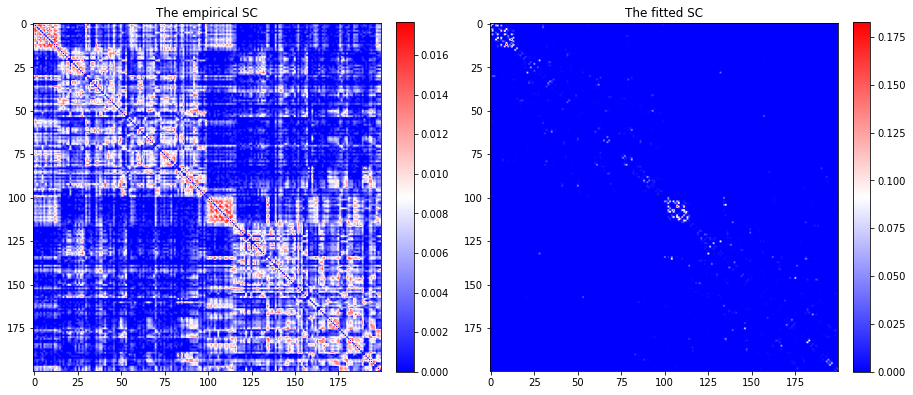

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 12))
im0 = ax[0].imshow(sc, cmap='bwr')
ax[0].set_title('The empirical SC')
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
im1 = ax[1].imshow(F.model.sc_fitted.detach().numpy(), cmap='bwr')
ax[1].set_title('The fitted SC')
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
plt.show()


Plot the EEG



AttributeError: 'OutputNM' object has no attribute 'P_test'

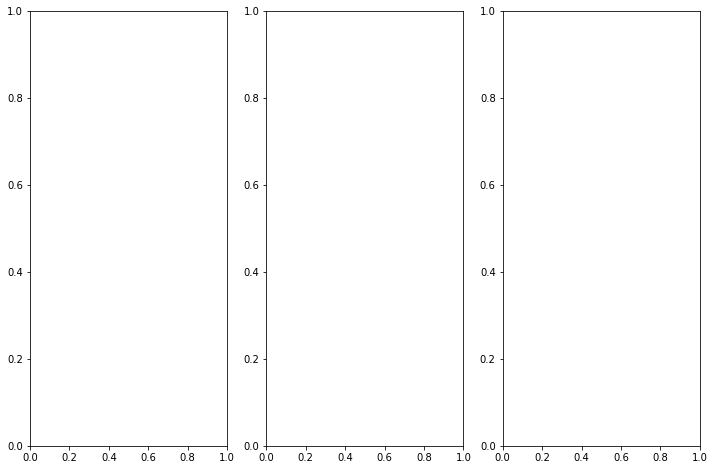

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(F.output_sim.P_test.T)
ax[0].set_title('Test: sourced EEG')
ax[1].plot(F.output_sim.eeg_test.T)
ax[1].set_title('Test')
ax[2].plot(eeg_data.T)
ax[2].set_title('empirical')
plt.show()
